# Download vlr-dataset and place into root



# Generate Spectrograms


Run following command

mkdir spectrograms
mkdir spectrograms/1

seq 0 16270 | xargs -I{} -n 1 -P 20 python generate_spec.py --N {} 


# Train and Eval Dino 

%cd dino

pip install timm

pip install torchvision -U

python main_dino.py --arch 'vit_base' --batch_size_per_gpu 32 --epochs 200 --data_path ./../vlr-dataset/spectrograms/ 

python eval_knn.py --arch 'vit_base' --batch_size_per_gpu 64 --data_path ./../vlr-dataset/spectrograms/  --pretrained_weights ./checkpoint0100.pth --dump_features ./../vlr-dataset/dino/


In [148]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import skimage.io
import glob
import tqdm
import os
from generate_spec import process_audio_file
from audio_helper import *
from lyric_helper import *
import random
import matplotlib.pyplot as plt

class EmbeddingLoader:
    
    def __init__(self):
        #preloading data 
        folder_name='./vlr-dataset/word_embeddings/BERT/'
        self.track_id_embedding_dict = {}
        with open(folder_name+'track_id_embedding_dict.pkl', 'rb') as f:
            self.track_id_embedding_dict = pickle.load(f)
        self.get_all_track_id_lyrics = np.load(folder_name+"track_id_list.npy").tolist()
        self.feats = torch.load('./vlr-dataset/dino/trainfeat.pth').numpy()
        self.song_list = torch.load('./vlr-dataset/dino/trainfname.pth')
        
        with open(folder_name+'genre_track_id_dict.pkl','rb') as f:
            self.genre_to_track_id_list = pickle.load(f)
        
    def invert_genre_to_track_id_list(self):
        self.track_id_to_genre_list = {}
        for genre in self.genre_to_track_id_list:
            track_list = self.genre_to_track_id_list[genre]
            for track in track_list:
                if not track in self.track_id_to_genre_list:
                    self.track_id_to_genre_list[track]=[]
                self.track_id_to_genre_list[track].append(genre)
        
    def extract(self):
        self.track_id_list = get_intersection_track_id(get_all_track_id_lyrics(self),get_all_track_id_audio())
        self.track_id_list.sort()
        self.invert_genre_to_track_id_list() # track_id_to_genre_list
        self.audio_embeddings = np.stack([track_id_to_audio_embedding(x,self) for x in self.track_id_list],axis=0)
        self.lyrics_embeddings = np.stack([track_id_to_lyric_embedding(x,self) for x in self.track_id_list],axis=0)
        self.song_paths = [track_id_to_filename(x,self) for x in self.track_id_list]
        self.genre_list_list =[self.track_id_to_genre_list[x] for x in self.track_id_list]
        
    def knn_kfn(self,i=None, B=1.0 ,k=5):
        i = i if i!=None else random.randint(0,self.audio_embeddings.shape[0]-1)
        search_embeddings = np.concatenate([self.audio_embeddings*B,self.lyrics_embeddings*(1.0-B)],axis=1)
        return self.shazam_embedding(search_embeddings[i:i+1],search_embeddings,k=k)
    
    def index_to_song_name(self,i):
        return self.song_paths[i]
    
    
    def shazam_embedding(self,embedding,search_embeddings,k=5):
        dists = np.linalg.norm(search_embeddings-embedding,axis=1)
        ci = (np.argsort(dists))
        # print(ci[1:k+1])
        return ci[1:k+1], ci[-k:]
    
    def plot_histogram(self):
        auds = self.audio_embeddings.reshape(-1)
        lyrs = self.lyrics_embeddings.reshape(-1)

        plt.hist(lyrs,bins=100)
        plt.title('lyrics embedding values')
        plt.show()
        plt.close()
        
        plt.hist(auds, bins = 100)
        plt.title('audio embedding values')
        plt.show()
        plt.close()
    def eval_song_index(self,i,B,k):
        present_genres = self.genre_list_list[i]
        nns = self.knn_kfn(i=i,B=B,k=k)[0]
        total_metric = 0.0
        for genre in present_genres:
            score_multiplier = (1.0/float(len(present_genres)))
            nn_count=0.0
            for nn in nns:
                if genre in self.genre_list_list[nn]:
                    nn_count=nn_count+1
            total_metric = total_metric + ((nn_count/float(k))*score_multiplier)
        return total_metric
    def plot_metric1(self):
        x=np.linspace(0.0,1.0,10).tolist()
        y=[]
        song_ids_to_eval=list(range(len(self.song_paths)))
        import random
        random.shuffle(song_ids_to_eval)
        song_ids_to_eval=song_ids_to_eval
        for b in x:
            y.append(self.metric1_genre(song_ids_to_eval,B=b,k=5))
            
        plt.plot(x,y)
        plt.show()
        plt.close()
            
    def metric1_genre(self,song_ids_to_eval,B=1.0,k=5):
        score=0.0
        
        for i in song_ids_to_eval:
            score = score+self.eval_song_index(i,B,k)
        score = score/float(len(song_ids_to_eval))
        return score

# Initialize the embeddings loader for fast compute


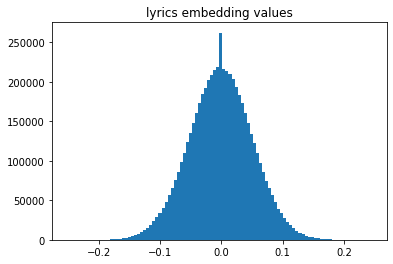

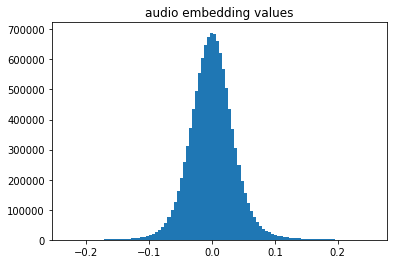

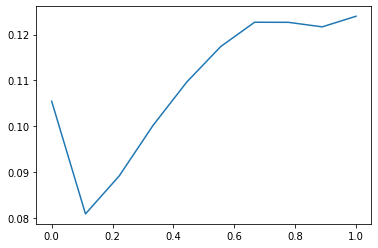

In [150]:
        
embedding_loader = EmbeddingLoader()
embedding_loader.extract()
embedding_loader.plot_histogram()
# embedding_loader.plot_metric1()



# Select a Song 

In [165]:

seed = 200
B=1
#good seeds 12028 sweet child, 268 pink floyd
import IPython.display as ipd
print(embedding_loader.song_paths[seed])


ipd.Audio(embedding_loader.song_paths[seed]) # load a local WAV file

# for name in nearest_songs:
#     ipd.Audio(name) # load a local WAV file

./vlr-dataset/song_previews/Golden Years   M Phazes Remix_Harlem Yu_06HUJRcD0t95ogCb2pMQJF.mp3


In [166]:
os.system('mkdir '+str(seed))
os.system('mkdir '+str(seed)+'/n_B'+str(B))
os.system('mkdir '+str(seed)+'/f_B'+str(B))

os.system('cp \"'+embedding_loader.song_paths[seed]+'\" \"'+str(seed)+'/'+embedding_loader.song_paths[seed].split('/')[-1]+'\"' )

result = embedding_loader.knn_kfn(i=seed,B=B)
nearest_songs = [embedding_loader.song_paths[i] for i in result[0]]
farthest_songs = [embedding_loader.song_paths[i] for i in result[1]]
print(result[0])
print(list([os.system(('cp \"'+embedding_loader.song_paths[i]+'\" \"'+str(seed)+'/n_B'+str(B)+'/'+embedding_loader.song_paths[i].split('/')[-1]+'\"' ).replace('\\','')) for i in result[0]]))
print(list([os.system(('cp \"'+embedding_loader.song_paths[i]+'\" \"'+str(seed)+'/f_B'+str(B)+'/'+embedding_loader.song_paths[i].split('/')[-1]+'\"' ).replace('\\','')) for i in result[1]]))

print(len(farthest_songs))

[ 9248   739  4556  4609 14480]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5
[13128  1391 14363  7976  3844]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5
[ 1997  9863 11329 11275  3507]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5
[ 8041  7778  6153 14215 13510]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5
[14395  5635  5366  6192  1116]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5
[11716  7267  8041  8831  6921]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5
[ 6119 13700 13056  9665 13457]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5
[10463  9017  4770 11235  7080]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5
[ 6119  5290 13056   144 13256]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
5


# Nearest Neighbours


In [ ]:
print(nearest_songs[0])
ipd.Audio(nearest_songs[0])

In [157]:
print(nearest_songs[1])
ipd.Audio(nearest_songs[1])

./vlr-dataset/song_previews/Almost Forgot_Against The Current_0htezQjIT0FNJQoZb6EJql.mp3


In [158]:
print(nearest_songs[2])
ipd.Audio(nearest_songs[2])

./vlr-dataset/song_previews/Tell Em_Cochise_7nc7mlSdWYeFom84zZ8Wr8.mp3


In [159]:
print(nearest_songs[3])
ipd.Audio(nearest_songs[3])

./vlr-dataset/song_previews/Black   Blue_Ellie Goulding_49ZEWSKtYA3vpPdPLDW9b3.mp3


In [ ]:
print(nearest_songs[4])
ipd.Audio(nearest_songs[4])

# Fastest Neighbours

In [161]:
print(farthest_songs[4])
ipd.Audio(farthest_songs[4])

./vlr-dataset/song_previews/Intro to She's Got a Way   Live April 1972 At Sigma Sound Studios  WMMR Radio  Philadelphia  PA_Billy Joel_7aGuQziDHmk2xXEmRSHcYK.mp3


In [162]:
print(farthest_songs[3])
ipd.Audio(farthest_songs[3])

./vlr-dataset/song_previews/Intro to Long  Long Time   Live April 1972 At Sigma Sound Studios  WMMR Radio  Philadelphia  PA_Billy Joel_5wHLqiR8PqpIT6nE0ifntM.mp3


In [101]:
print(farthest_songs[2])
ipd.Audio(farthest_songs[2])

./vlr-dataset/song_previews/Bangarang  feat. Sirah _One Direction_6VRhkROS2SZHGlp0pxndbJ.mp3


In [102]:
print(farthest_songs[1])
ipd.Audio(farthest_songs[1])

./vlr-dataset/song_previews/Deep Down Low_Valentino Khan_46rZgRYU1H5Xnv0n75OGis.mp3


In [103]:
print(farthest_songs[0])
ipd.Audio(farthest_songs[0])

./vlr-dataset/song_previews/Wild Thing_Tone Loc_0gljI0CtjpdZK6ecidfxto.mp3
